In [7]:
import numpy as np
import pandas as pd
import pyflux as pf
import datetime as datetime
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline
import seaborn as sns


In [93]:
pwd

'/Users/davidsmith/Documents/Galvanize/Capstone'

In [183]:
# the data is sitting in the model list already under forecast
# Don't start from initial_distrib - just go to model list
#dist_list = pickle.load(open('data/initial_distrib', 'rb'))
model_list = pickle.load(open('src/initial_model_results', 'rb'))



In [181]:
dist_list = []
for i in range(len(model_list)):
    dist_list.append(model_list[i]['forecast'])

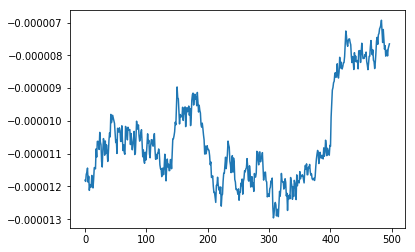

In [184]:
plt.plot(model_list[0]['forecast'][:,3])

In [ ]:
# x = [random.gauss(3,1) for _ in range(400)]
# y = [random.gauss(4,2) for _ in range(400)]

# bins = numpy.linspace(-10, 10, 100)

# pyplot.hist(x, bins, alpha=0.5, label='x')
# pyplot.hist(y, bins, alpha=0.5, label='y')
# pyplot.legend(loc='upper right')
# pyplot.show()

## NEED TO RECREATE THE CROSS VALIDATION SET OF FORWARDS

In [14]:
# NOTE: this will clean up what we need to do later
X_fwds_cv = pickle.load(open('data/fwd_cv_data', 'rb'))
X_fwds_cv.describe()

,six_m,one_y,two_y,three_y,five_y,seven_y,ten_y,d_six_m,d_one_y,d_two_y,d_three_y,d_five_y,d_seven_y,d_ten_y
count,3313.000000,3313.000000,3313.000000,3313.000000,3313.000000,3313.000000,3313.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000,3312.000000
mean,0.012523,0.014444,0.017678,0.022241,0.029422,0.036375,0.039071,-0.000006,-0.000006,-0.000007,-0.000007,-0.000006,-0.000006,-0.000006
std,0.016720,0.015907,0.013664,0.012248,0.010659,0.009715,0.010204,0.000385,0.000446,0.000712,0.000757,0.000795,0.000818,0.000700
min,0.000200,0.000900,0.002502,0.004105,0.009730,0.017387,0.018246,-0.004900,-0.004344,-0.006169,-0.004756,-0.007153,-0.007652,-0.007034
25%,0.001200,0.002502,0.007921,0.013559,0.022186,0.028230,0.030026,-0.000100,-0.000200,-0.000401,-0.000408,-0.000457,-0.000458,-0.000406
50%,0.003100,0.006612,0.012949,0.019413,0.027740,0.033950,0.037701,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000021,0.000000
75%,0.019500,0.022931,0.024954,0.028101,0.038071,0.045670,0.049184,0.000100,0.000200,0.000401,0.000405,0.000431,0.000441,0.000377
max,0.053300,0.053600,0.053497,0.053087,0.053215,0.055391,0.061604,0.007500,0.003650,0.005763,0.003650,0.004026,0.011311,0.003459


In [15]:
total_obs = len(X_fwds)
train_int = int(round(total_obs*.7, 0))
cv_int = int(round(total_obs*.85, 0))

fwd_train = X_fwds[0:train_int]
fwd_cv = X_fwds[train_int:cv_int]
fwd_test = X_fwds[cv_int:]

In [18]:
X_fwds = X_fwds.drop(X_fwds.index[0])
fwd_cv.head()

,six_m,one_y,two_y,three_y,five_y,seven_y,ten_y,d_six_m,d_one_y,d_two_y,d_three_y,d_five_y,d_seven_y,d_ten_y
Date,,,,,,,,,,,,,,
2015-04-08,0.0010,0.003404,0.008825,0.015172,0.021082,0.025724,0.025482,0.0000,0.000000,4.023631e-04,-0.000102,0.000608,-0.000052,0.000575
2015-04-09,0.0010,0.003404,0.009227,0.015677,0.021918,0.026240,0.025999,0.0000,0.000000,4.024835e-04,0.000505,0.000836,0.000517,0.000517
2015-04-10,0.0009,0.003905,0.009227,0.016081,0.021867,0.025950,0.025650,-0.0001,0.000501,-3.467865e-07,0.000404,-0.000052,-0.000290,-0.000349
2015-04-13,0.0011,0.003504,0.008724,0.016082,0.021411,0.026002,0.025448,0.0002,-0.000401,-5.029008e-04,0.000001,-0.000456,0.000052,-0.000203
2015-04-14,0.0010,0.003604,0.008523,0.015072,0.020981,0.025622,0.025009,-0.0001,0.000100,-2.011765e-04,-0.001011,-0.000430,-0.000380,-0.000439


In [80]:
column_names = X_fwds_cv.columns

ind = np.arange(7,14)
rate_titles = column_names[ind]

print(rate_titles)
print(rate_titles[0])
# indices = np.arange(7, len(column_names))
# print(indices)
# result = [column_names[i] for i in indices]


# result

Index(['d_six_m', 'd_one_y', 'd_two_y', 'd_three_y', 'd_five_y', 'd_seven_y',
       'd_ten_y'],
      dtype='object')
d_six_m


In [19]:
 X = X_fwd_cv[['d_six_m', 'd_one_y', 'd_two_y', 'd_three_y', 'd_five_y', 'd_seven_y', 'd_ten_y']].values

In [ ]:
# load up the model_list variable as well

In [101]:
model_list

[{'model_type': pyflux.arma.arma.ARIMA,
  'model_class': 'ARIMA',
  'name': 'Normal ARIMA(1,1,1)',
  'target': 'd_ten_y',
  'hyper_params': {'ar': 1, 'ma': 1, 'diff_ord': 0},
  'num_components': 1,
  'forecast': array([[-1.75356616e-05, -2.64040499e-05, -2.75835923e-05, ...,
          -8.87585339e-06, -1.74658700e-06,  3.61426357e-06],
         [-1.75397732e-05, -1.83241584e-05, -5.47445690e-05, ...,
          -3.41548816e-05, -7.60271712e-06, -1.77657559e-05],
         [-1.75203649e-05, -1.81502360e-05, -5.57792224e-05, ...,
          -4.30770488e-05, -1.30795868e-05, -1.66695983e-05],
         ...,
         [-6.76471146e-06, -3.49406666e-05, -4.24448303e-05, ...,
          -1.68653992e-05, -2.23543637e-05, -9.86041451e-06],
         [-1.20429870e-05, -2.16869331e-05, -9.46064284e-06, ...,
           1.53091343e-05,  3.92154098e-06, -5.01496510e-06],
         [-1.82628223e-05, -7.62782474e-06, -9.27906947e-06, ...,
          -2.41785736e-05, -2.02547077e-05, -7.22469363e-06]])},
 {'mo

In [100]:
model_index = 0

In [107]:
def plot_model_distributions(model_index, model_list, X_fwds, fig_filename=False):
    
    model_name = model_list[model_index]['name']
    
    column_names = X_fwds.columns
    ind = np.arange(7,14)
    rate_titles = column_names[ind]

    fig, axs = plt.subplots(7, 2, figsize = (15,15))
    super_title = model_name + ' Model Noise'
    fig.suptitle(super_title, fontsize=24)

    for i, ax in enumerate(axs.flatten()):
        if i%2==0:
            this_index = i/2
            this_index = int(this_index)
            this_rate = rate_titles[this_index]
            print("This is the index for the rows", this_index, ' with this rate ', this_rate)
            # Charts on left hand side are model noise
            ax.plot(model_list[model_index]['forecast'][:,this_index])
            ax.set_title(model_name +' Model error ' + this_rate+  ' forward rate')
            ax.grid()
            ax.set_facecolor('whitesmoke')
        else:
            sns.distplot(dist_list[0][:,0], hist=False, color = 'red', kde_kws={'shade': True}, ax=ax, label='ARIMA')
            sns.distplot(X[:,0], hist=False, color = 'black', kde_kws={'shade': True}, ax=ax, label='Actual daily change')

            ax.set_title('Distribution of ' + model_name + 'Model for '+ this_rate +' forward rate')
            ax.grid()
            ax.set_facecolor('whitesmoke')

    plt.tight_layout()
    fig.subplots_adjust(top = .92)
    # plt.savefig('plot_of_error.png')


This is the index for the rows 0  with this rate  d_six_m
This is the index for the rows 1  with this rate  d_one_y
This is the index for the rows 2  with this rate  d_two_y
This is the index for the rows 3  with this rate  d_three_y
This is the index for the rows 4  with this rate  d_five_y
This is the index for the rows 5  with this rate  d_seven_y
This is the index for the rows 6  with this rate  d_ten_y


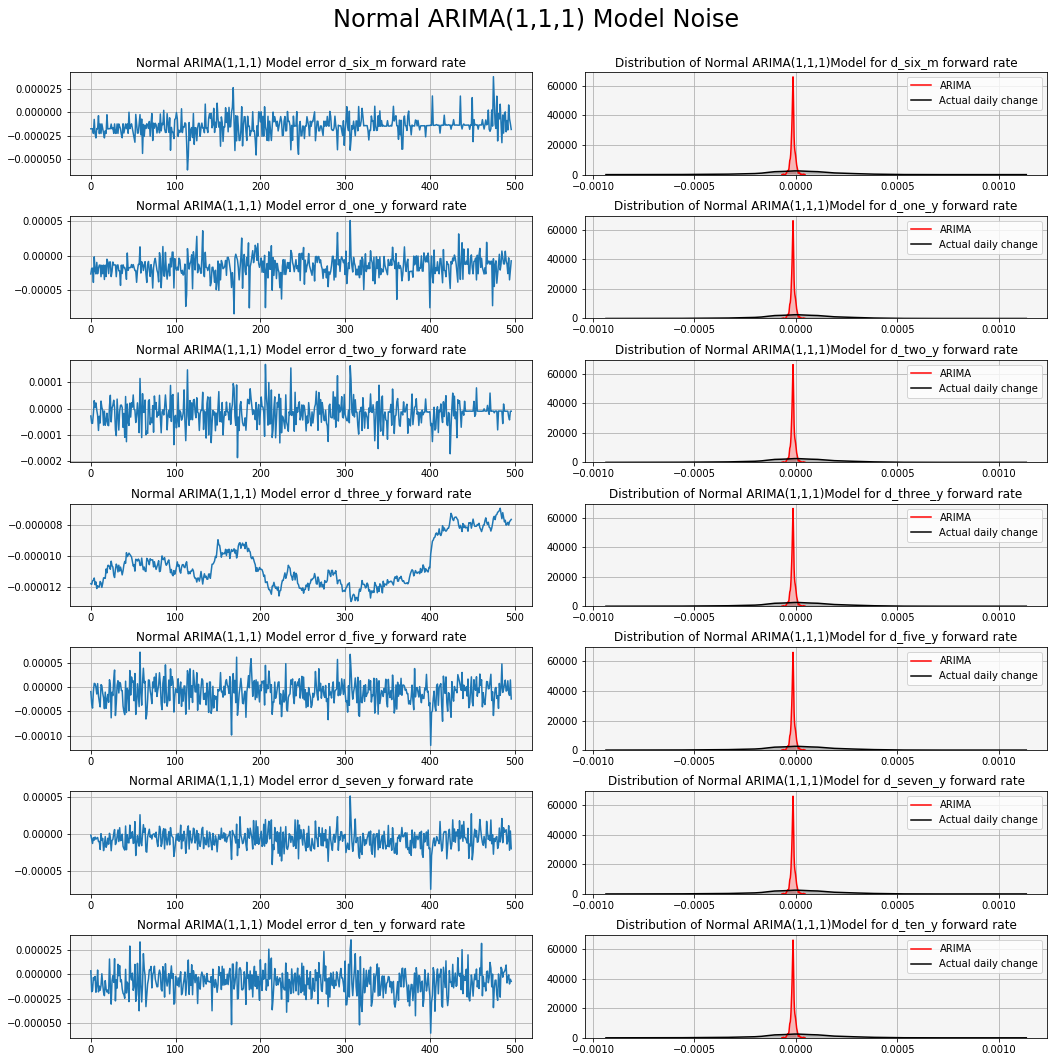

In [108]:
plot_model_distributions(model_index, model_list, X_fwds)

In [176]:
model_list[0]

{'model_type': pyflux.arma.arma.ARIMA,
 'model_class': 'ARIMA',
 'name': 'Normal ARIMA(1,0,1)',
 'target': 'd_ten_y',
 'hyper_params': {'ar': 1, 'ma': 1, 'diff_ord': 0},
 'num_components': 1,
 'forecast': array([[-1.75356616e-05, -2.64040499e-05, -2.75835923e-05, ...,
         -8.87585339e-06, -1.74658700e-06,  3.61426357e-06],
        [-1.75397732e-05, -1.83241584e-05, -5.47445690e-05, ...,
         -3.41548816e-05, -7.60271712e-06, -1.77657559e-05],
        [-1.75203649e-05, -1.81502360e-05, -5.57792224e-05, ...,
         -4.30770488e-05, -1.30795868e-05, -1.66695983e-05],
        ...,
        [-6.76471146e-06, -3.49406666e-05, -4.24448303e-05, ...,
         -1.68653992e-05, -2.23543637e-05, -9.86041451e-06],
        [-1.20429870e-05, -2.16869331e-05, -9.46064284e-06, ...,
          1.53091343e-05,  3.92154098e-06, -5.01496510e-06],
        [-1.82628223e-05, -7.62782474e-06, -9.27906947e-06, ...,
         -2.41785736e-05, -2.02547077e-05, -7.22469363e-06]])}

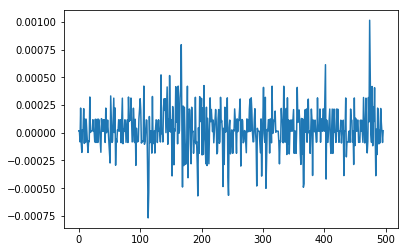

In [31]:
this_index=0
plt.plot(dist_list[model_number][:,this_index])

In [48]:
test = 0/2
test = int(test)
test

0

In [ ]:
# NEED TO ADD DATES

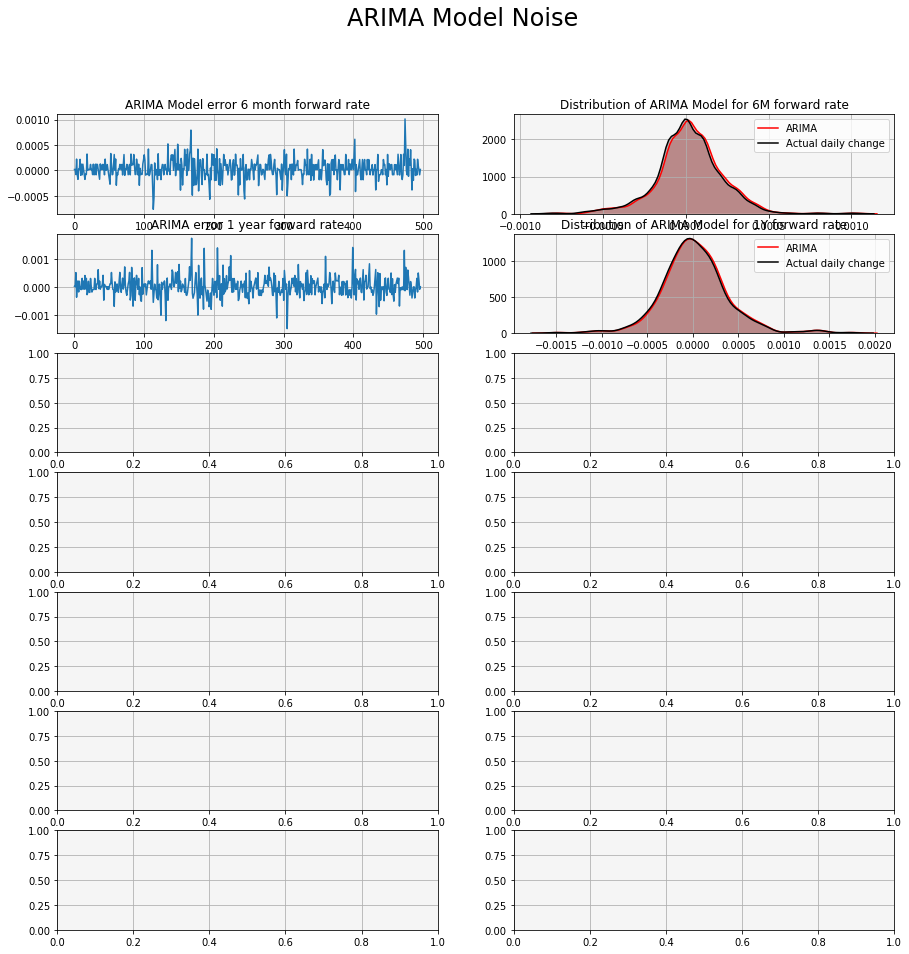

In [26]:
fig, axs = plt.subplots(7, 2, figsize = (15,15))
fig.suptitle('ARIMA Model Noise', fontsize=24)
axs[0,0].plot(dist_list[0][:,0])
axs[0,0].set_title('ARIMA Model error 6 month forward rate')
sns.distplot(dist_list[0][:,0], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[0,1], label='ARIMA')
sns.distplot(X[:,0], hist=False, color = 'black', kde_kws={'shade': True}, ax=axs[0,1], label='Actual daily change')

axs[0,1].set_title('Distribution of ARIMA Model for 6M forward rate')


axs[1,0].plot(dist_list[0][:,1])
axs[1,0].set_title('ARIMA error 1 year forward rate')
sns.distplot(dist_list[0][:,1], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[1,1], label = 'ARIMA')
sns.distplot(X[:,1], hist=False, color = 'black', kde_kws={'shade': True}, ax=axs[1,1], label='Actual daily change')
axs[1,1].set_title('Distribution of ARIMA Model for 1Y forward rate')


# axs[2,0].plot(fcst_error[:,2])
# axs[2,0].set_title('Base Model error 2 year forward rate')
# #axs[2,1].hist(fcst_error[:,0], bins = 20)
# sns.distplot(fcst_error[:,2], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[2,1])
# axs[2,1].set_title('Distribution of ARIMA Model for 2Y Forward rate')


# axs[3,0].plot(fcst_error[:,3])
# axs[3,0].set_title('Base Model error 3 year forward rate')
# #axs[3,1].hist(fcst_error[:,0], bins = 20)
# sns.distplot(fcst_error[:,3], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[3,1])
# axs[3,1].set_title('Distribution of ARIMA Model for 3Y forward rate')


# axs[4,0].plot(fcst_error[:,4])
# axs[4,0].set_title('Base Model error 5 year forward rate')
# #axs[4,1].hist(fcst_error[:,0], bins = 20)
# sns.distplot(fcst_error[:,4], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[4,1])
# axs[4,1].set_title('Distribution of ARIMA Model for 5Y forward rate')


# axs[5,0].plot(fcst_error[:,5])
# axs[5,0].set_title('Base Model error 7 year forward rate')
# #axs[5,1].hist(fcst_error[:,0], bins = 20)
# sns.distplot(fcst_error[:,5], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[5,1])
# axs[5,1].set_title('Distribution of ARIMA Model for 7Y Forward rate')


# axs[6,0].plot(fcst_error[:,6])
# axs[6,0].set_title('ARIMA Model error 10 year forward rate')

# #axs[6,1].hist(fcst_error[:,0], bins = 20)
# sns.distplot(fcst_error[:,6], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[6,1])
# axs[6,1].set_title('Distribution of ARIMA Model for 10Y forward rate')

axs[0,0].grid()
axs[0,1].grid()

axs[1,0].grid()
axs[1,1].grid()

axs[2,0].grid()
axs[2,1].grid()
axs[3,0].grid()
axs[3,1].grid()
axs[4,0].grid()
axs[4,1].grid()
axs[5,0].grid()
axs[5,1].grid()
axs[6,0].grid()
axs[6,1].grid()

axs[0,0].set_facecolor('whitesmoke')
axs[1,0].set_facecolor('whitesmoke')
axs[2,0].set_facecolor('whitesmoke')
axs[3,0].set_facecolor('whitesmoke')
axs[4,0].set_facecolor('whitesmoke')
axs[5,0].set_facecolor('whitesmoke')
axs[6,0].set_facecolor('whitesmoke')

axs[0,1].set_facecolor('whitesmoke')
axs[1,1].set_facecolor('whitesmoke')
axs[2,1].set_facecolor('whitesmoke')
axs[3,1].set_facecolor('whitesmoke')
axs[4,1].set_facecolor('whitesmoke')
axs[5,1].set_facecolor('whitesmoke')
axs[6,1].set_facecolor('whitesmoke')



# fig.tight_layout()
# fig.subplots_adjust(top = .92)
# plt.savefig('plot_of_error.png')


In [152]:
these_dates = fwd_cv.index
these_dates

DatetimeIndex(['2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13',
               '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-17',
               '2015-04-20', '2015-04-21',
               ...
               '2017-03-20', '2017-03-21', '2017-03-22', '2017-03-23',
               '2017-03-24', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', name='Date', length=497, freq=None)

In [122]:
model_list[0]['name']

'Normal ARIMA(1,1,1)'

In [191]:
a = np.max(model_list[2]['forecast'])
print(a)
b= np.min(model_list[2]['forecast'])
print(b)

-3.880869348689812e-06
-1.862157534246575e-05


In [197]:
x_tick_index = [1, 101, 201, 301, 401]

y_max = 0.0002
y_min = -0.0002


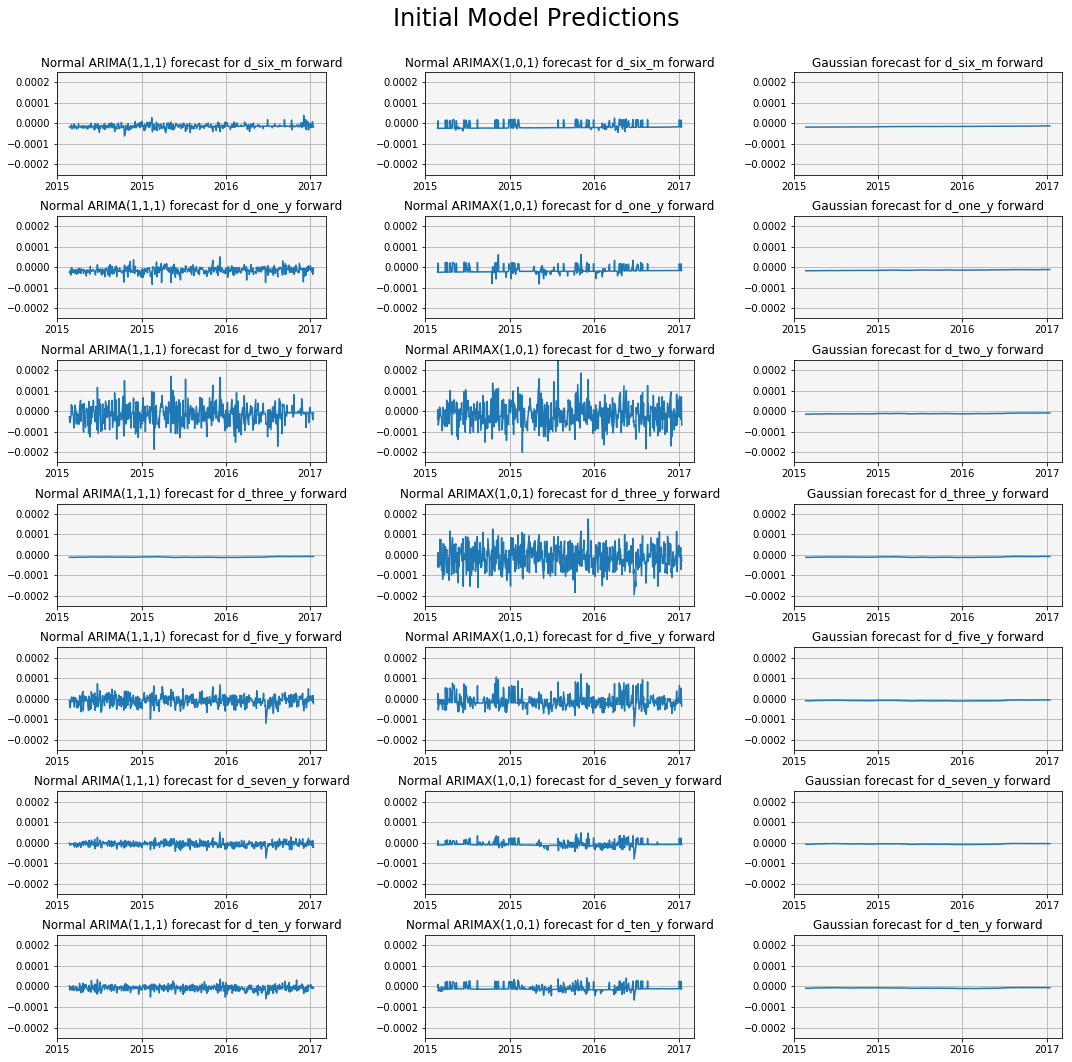

In [196]:
fig, axs = plt.subplots(7, 3, figsize = (15,15))
fig.suptitle('Initial Model Predictions', fontsize=24)

for i, ax in enumerate(axs.flatten()):

    this_row = int(i/3)
    this_rate = rate_titles[this_row]

    this_column = i%3
    this_name = model_list[this_column]['name']
    this_title = this_name + ' forecast for ' + this_rate + ' forward'
    #print(this_title)
    ax.plot(these_dates, model_list[this_column]['forecast'][:,this_row])
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 250))
    #ax.x_axis.set_ticks(x_tick_index)
    ax.set_title(this_title)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.grid()
    ax.set_facecolor('whitesmoke')
plt.tight_layout() 
fig.subplots_adjust(top = .92)
plt.savefig('initial_model_predictions.png')


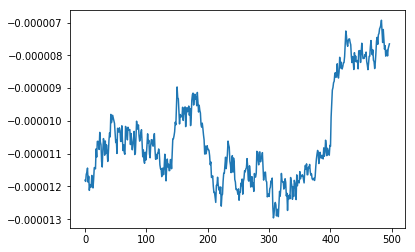

In [168]:
plt.plot(model_list[0]['forecast'][:,3])

In [166]:
# calculate the error for all of the distributions
# plot the distributions together


0
0
0
1
1
1
2
2
2
3


In [ ]:
fig, axs = plt.subplots(7, 1, figsize = (15,15))
fig.suptitle('Model Noise', fontsize=24)
axs[0,0].plot(dist_list[0][:,0])
axs[0,0].set_title('ARIMA Model error 6 month forward rate')
sns.distplot(dist_list[0][:,0], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[0,1], label='ARIMA')
sns.distplot(X[:,0], hist=False, color = 'black', kde_kws={'shade': True}, ax=axs[0,1], label='Actual daily change')

axs[0,1].set_title('Distribution of ARIMA Model for 6M forward rate')


axs[1,0].plot(dist_list[0][:,1])
axs[1,0].set_title('ARIMA error 1 year forward rate')
sns.distplot(dist_list[0][:,1], hist=False, color = 'red', kde_kws={'shade': True}, ax=axs[1,1], label = 'ARIMA')
sns.distplot(X[:,1], hist=False, color = 'black', kde_kws={'shade': True}, ax=axs[1,1], label='Actual daily change')
axs[1,1].set_title('Distribution of ARIMA Model for 1Y forward rate')
